# Introduction

Customer churn is the phenomenon where clients end their contracts or relationships with a business or service provider. It illustrates the rate at which clients discontinue utilising a business's goods or services over a predetermined time frame. Because it directly affects sales, expansion, and client retention, churn is a crucial business statistic.

The churn label in the Churn dataset specifies whether a client has left or not. One who has chosen to stop using the company's services or their membership is referred to as a churned customer. A non-churned customer, on the other hand, is one who maintains their engagement and relationship with the business.

In this notebook, we will explore the dataset and then model it with 4 Classification algorithms viz. Random Forest, Logistics Regression, ANN and XGBoost. Also, we will analyze the model's prediction with the help of metrics and ROC curve.

# Importing data and libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RepeatedStratifiedKFold
import seaborn as sn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

/kaggle/input/customer-churn-dataset/customer_churn_dataset-testing-master.csv
/kaggle/input/customer-churn-dataset/customer_churn_dataset-training-master.csv


In [2]:
train_data =  pd.read_csv("/kaggle/input/customer-churn-dataset/customer_churn_dataset-training-master.csv")
test_data =pd.read_csv("/kaggle/input/customer-churn-dataset/customer_churn_dataset-testing-master.csv")

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CustomerID         64374 non-null  int64 
 1   Age                64374 non-null  int64 
 2   Gender             64374 non-null  object
 3   Tenure             64374 non-null  int64 
 4   Usage Frequency    64374 non-null  int64 
 5   Support Calls      64374 non-null  int64 
 6   Payment Delay      64374 non-null  int64 
 7   Subscription Type  64374 non-null  object
 8   Contract Length    64374 non-null  object
 9   Total Spend        64374 non-null  int64 
 10  Last Interaction   64374 non-null  int64 
 11  Churn              64374 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 5.9+ MB


# Data Pre-processing

In [5]:
train_data.isnull().sum()

CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

In [6]:
train_data.dropna(inplace=True)

In [7]:
test_data.isnull().sum()

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

Identify the Categorical variables and perform one hot encoding

In [8]:
Categorical_col = []
Numerical_col = []

In [9]:
for col in train_data.columns:
    if train_data[col].dtype == 'object':
        Categorical_col.append(col)
     
    else:
        Numerical_col.append(col)

In [10]:
Categorical_col

['Gender', 'Subscription Type', 'Contract Length']

In [11]:
Numerical_col

['CustomerID',
 'Age',
 'Tenure',
 'Usage Frequency',
 'Support Calls',
 'Payment Delay',
 'Total Spend',
 'Last Interaction',
 'Churn']

In [12]:
for col in Categorical_col:
    print(train_data[col].unique())

['Female' 'Male']
['Standard' 'Basic' 'Premium']
['Annual' 'Monthly' 'Quarterly']


Gender
Subscription Type
Contract Length


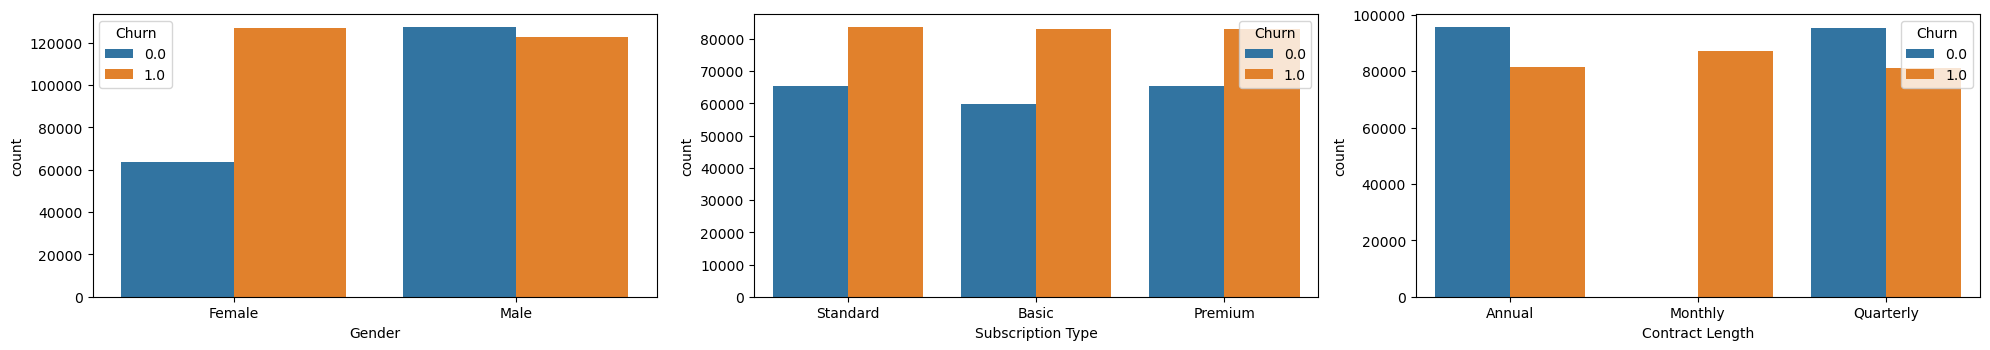

In [13]:
plot_num = 1
plt.figure(figsize=(20,10))
for i in Categorical_col:
    print(i)
    ax = plt.subplot(3,3,plot_num)
    sn.countplot(x=train_data[i], hue=train_data['Churn'])
    plot_num +=1
plt.tight_layout()

In [14]:
train_data_mdf = pd.get_dummies(data = train_data, columns=Categorical_col).copy()
train_data_mdf.head()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn,Gender_Female,Gender_Male,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Annual,Contract Length_Monthly,Contract Length_Quarterly
0,2.0,30.0,39.0,14.0,5.0,18.0,932.0,17.0,1.0,1,0,0,0,1,1,0,0
1,3.0,65.0,49.0,1.0,10.0,8.0,557.0,6.0,1.0,1,0,1,0,0,0,1,0
2,4.0,55.0,14.0,4.0,6.0,18.0,185.0,3.0,1.0,1,0,1,0,0,0,0,1
3,5.0,58.0,38.0,21.0,7.0,7.0,396.0,29.0,1.0,0,1,0,0,1,0,1,0
4,6.0,23.0,32.0,20.0,5.0,8.0,617.0,20.0,1.0,0,1,1,0,0,0,1,0


In [15]:
test_data_mdf = pd.get_dummies(data = test_data, columns=Categorical_col).copy()
test_data_mdf.tail()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn,Gender_Female,Gender_Male,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Annual,Contract Length_Monthly,Contract Length_Quarterly
64369,64370,45,33,12,6,21,947,14,1,1,0,1,0,0,0,0,1
64370,64371,37,6,1,5,22,923,9,1,0,1,0,0,1,1,0,0
64371,64372,25,39,14,8,30,327,20,1,0,1,0,1,0,0,1,0
64372,64373,50,18,19,7,22,540,13,1,1,0,0,0,1,0,1,0
64373,64374,52,45,15,9,25,696,22,1,1,0,0,0,1,0,1,0


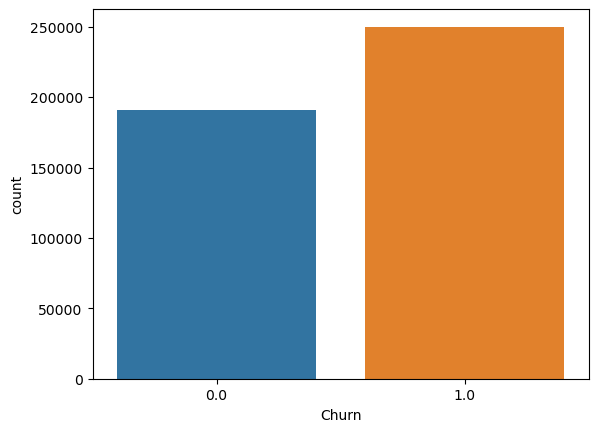

In [16]:
sn.countplot(data=train_data, x='Churn')
plt.show()

<Axes: >

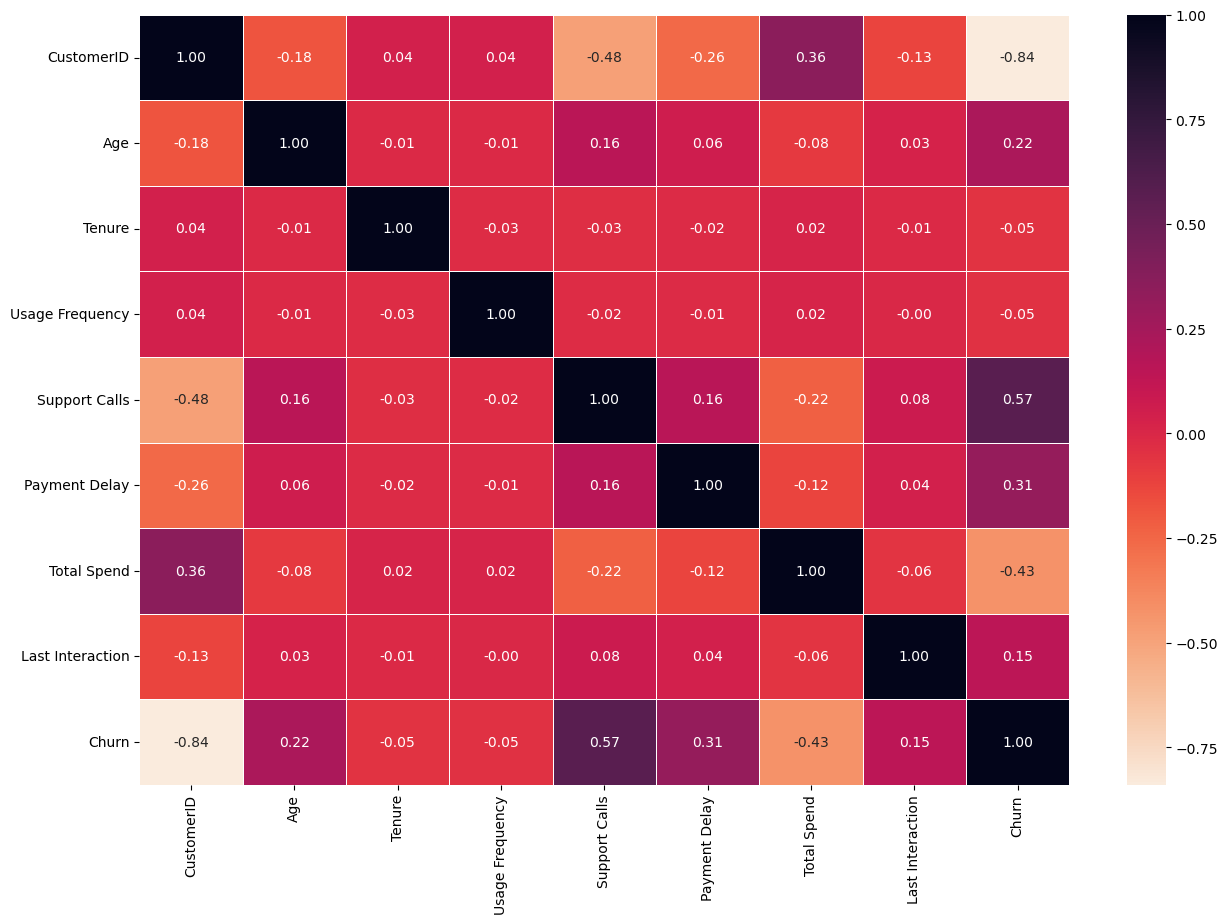

In [17]:
correlation_matrix = train_data.corr(numeric_only=True)
plt.figure(figsize=(15, 10))
sn.heatmap(correlation_matrix, annot=True, cmap='rocket_r', linewidths=0.5, fmt='.2f')

# Data Visualisation

In [18]:
cols = ['Age', 'Tenure','Usage Frequency','Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']

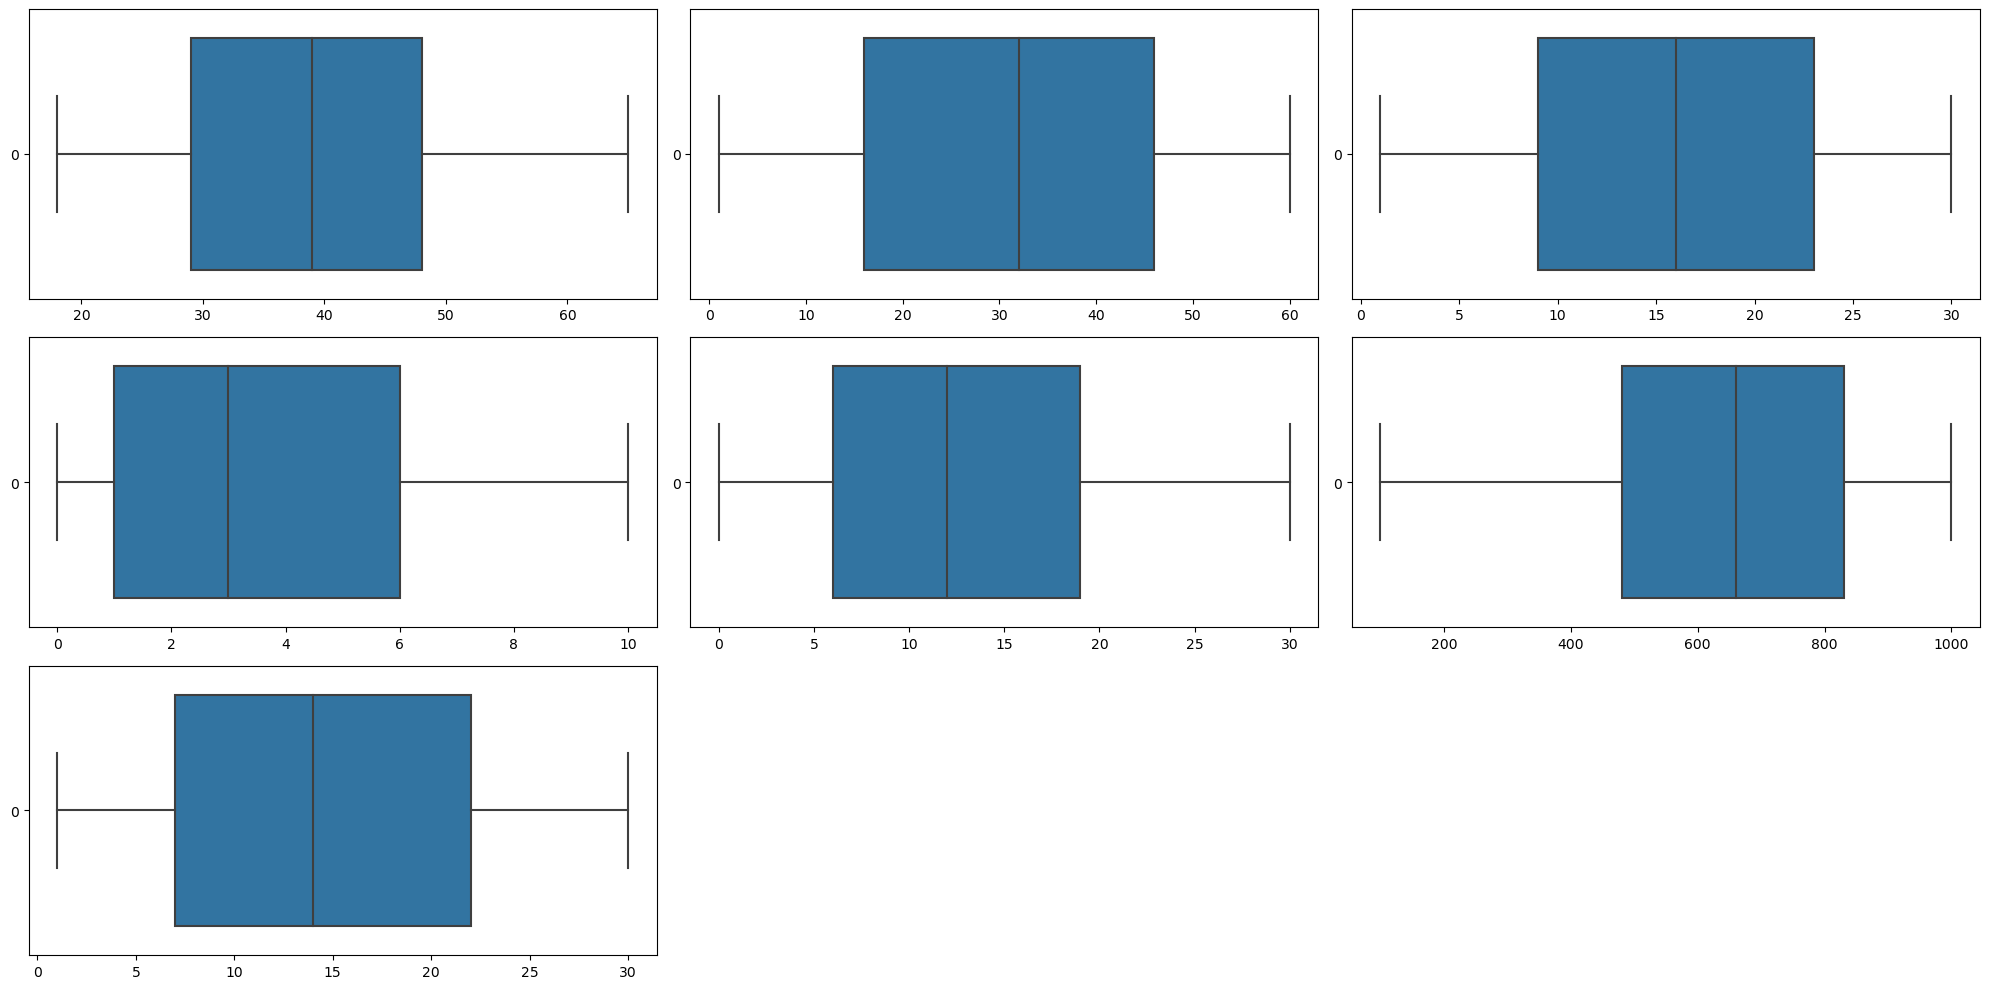

In [19]:
plot_num = 1
plt.figure(figsize=(20,10))
for col in cols:
    ax = plt.subplot(3,3,plot_num)
    sn.boxplot(train_data[col], orient='h')
    plot_num +=1
plt.tight_layout()

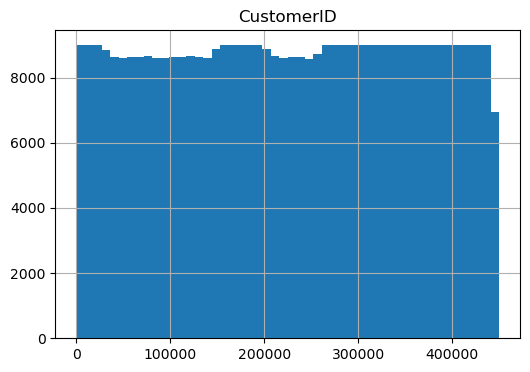

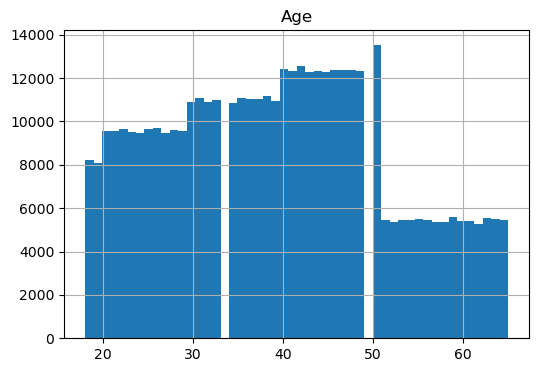

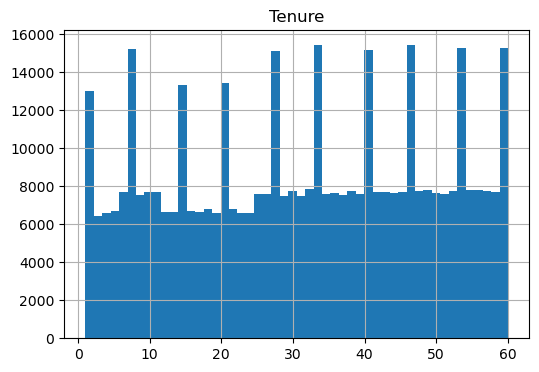

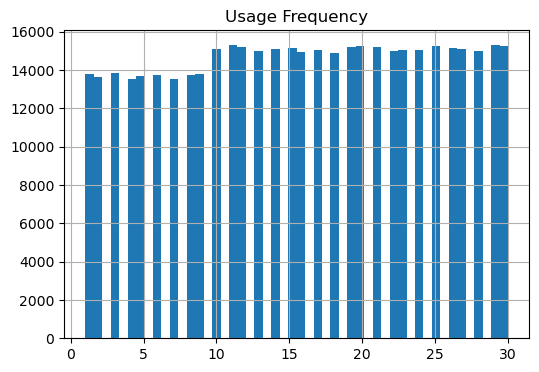

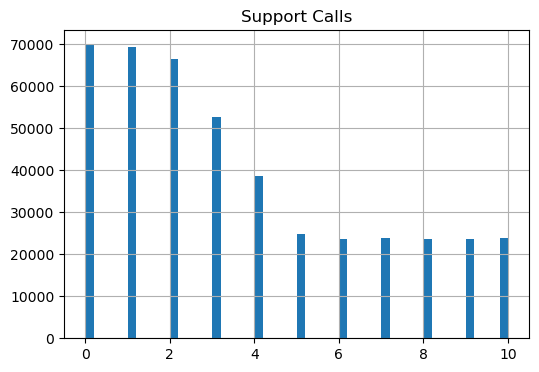

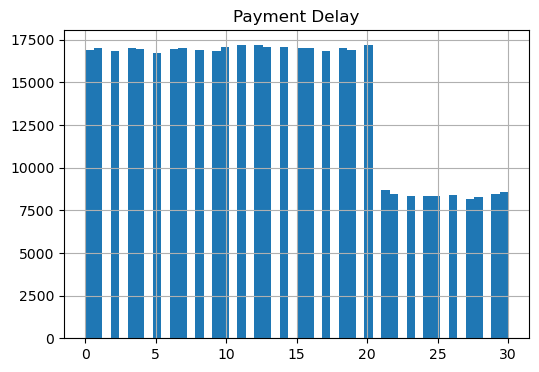

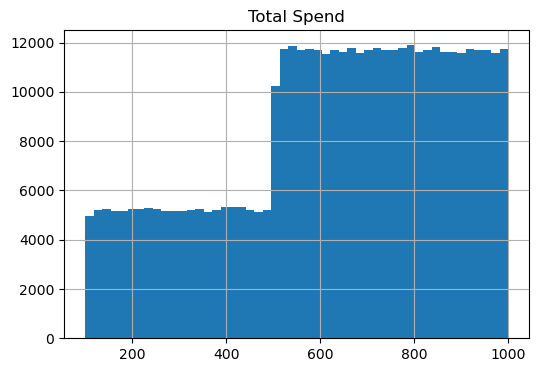

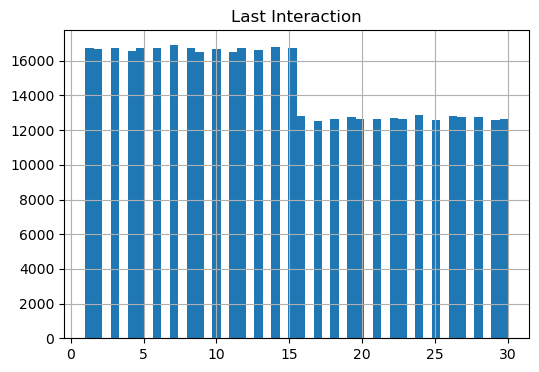

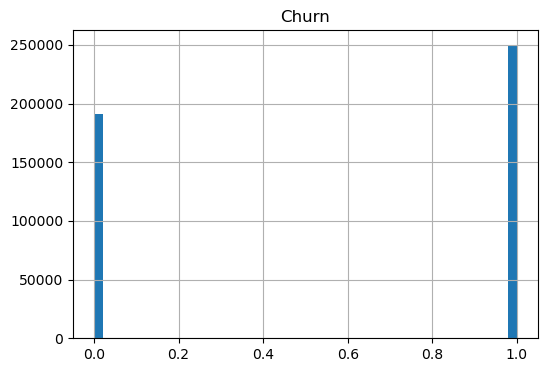

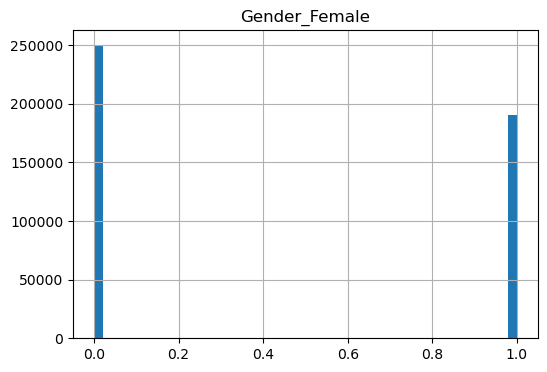

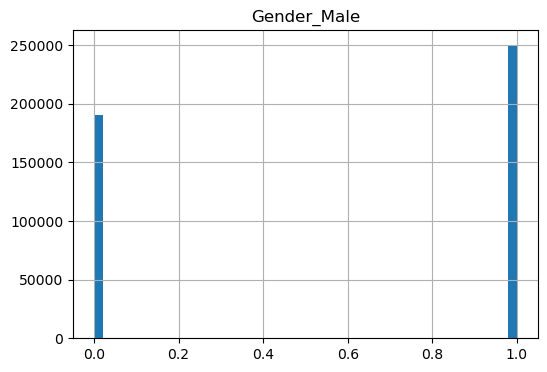

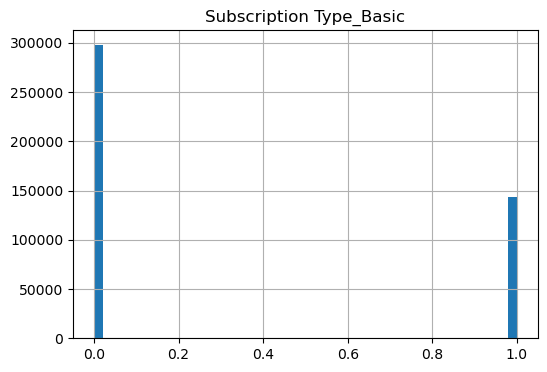

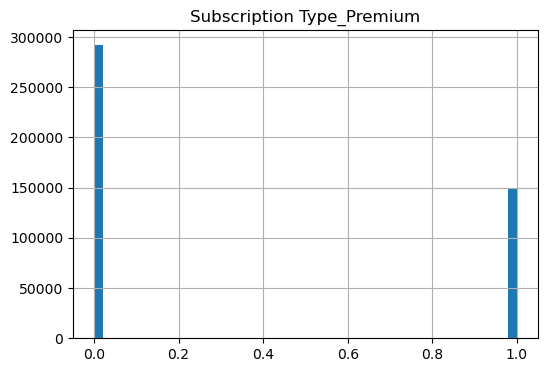

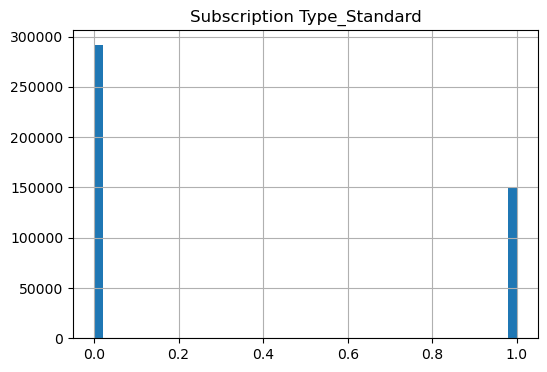

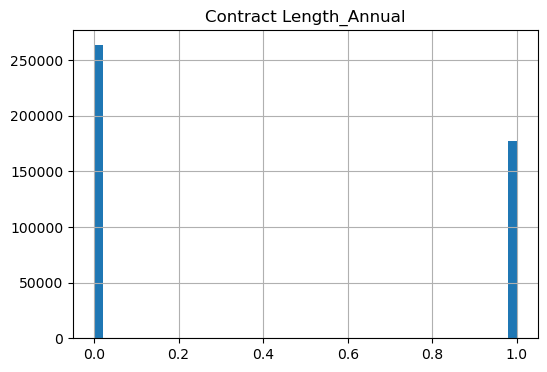

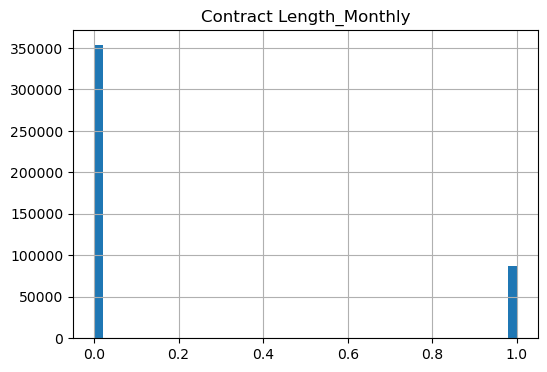

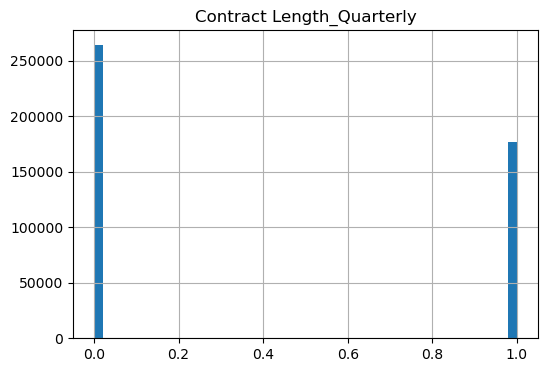

In [20]:
for column in test_data_mdf.columns:
    fig, ax = plt.subplots(figsize=(6, 4))  # Adjust figsize as needed
    train_data_mdf[column].hist(bins=50, ax=ax)
    plt.title(f"{column}")
    plt.show()

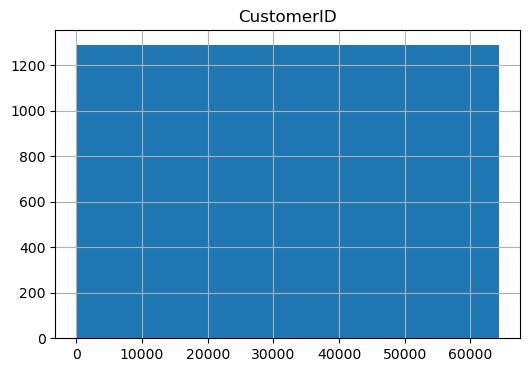

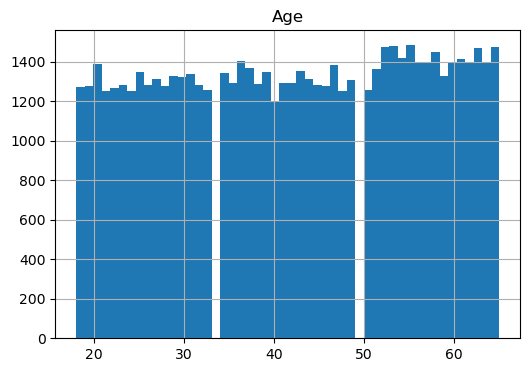

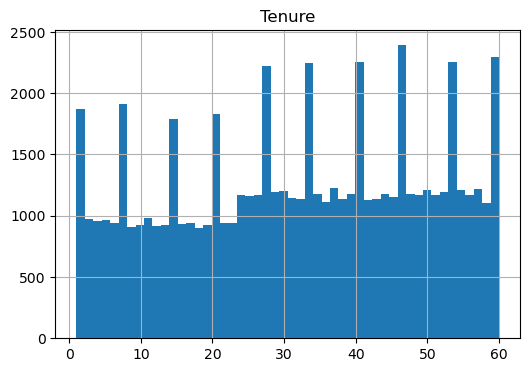

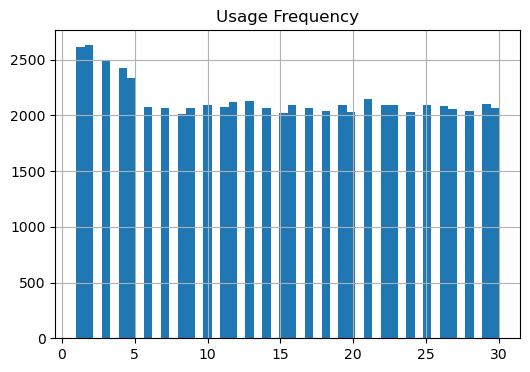

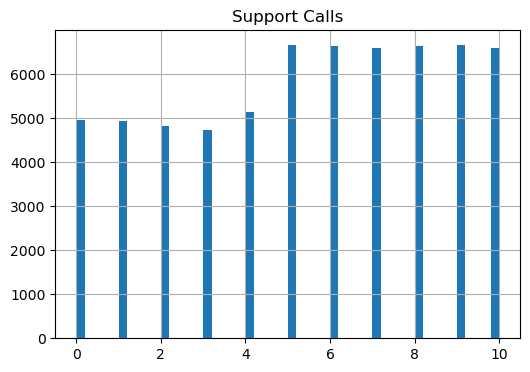

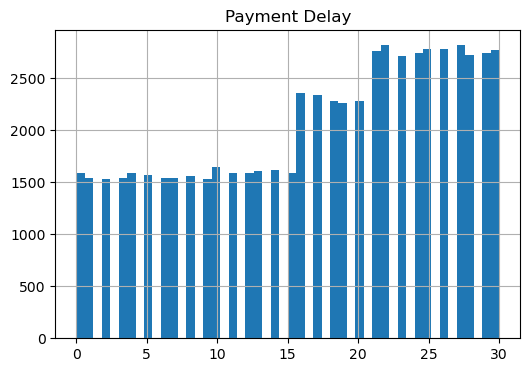

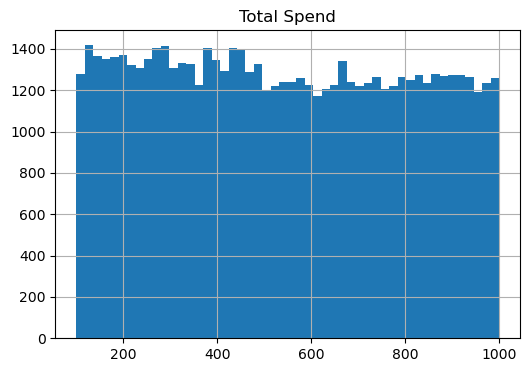

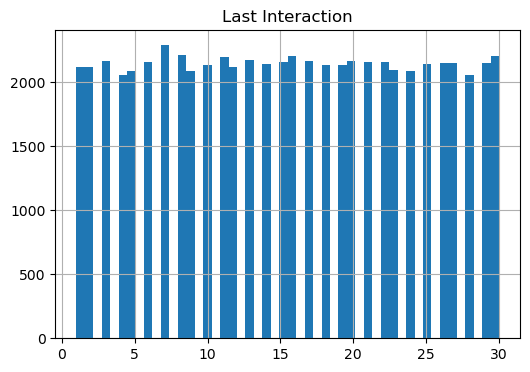

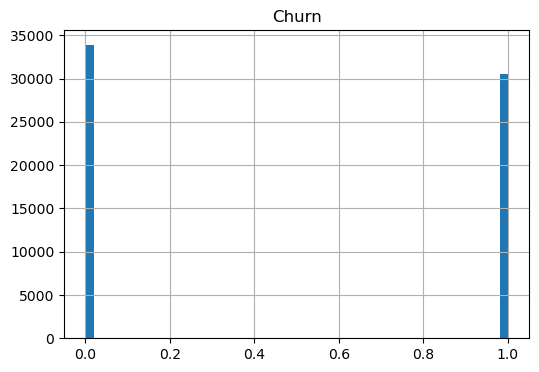

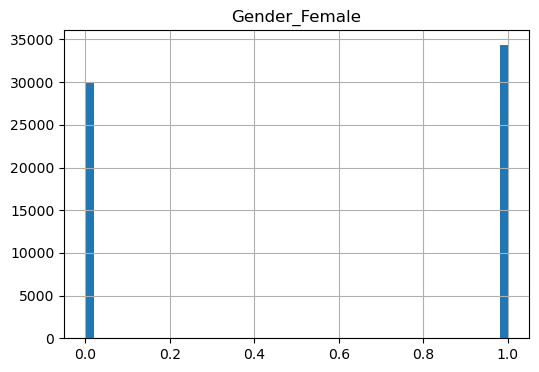

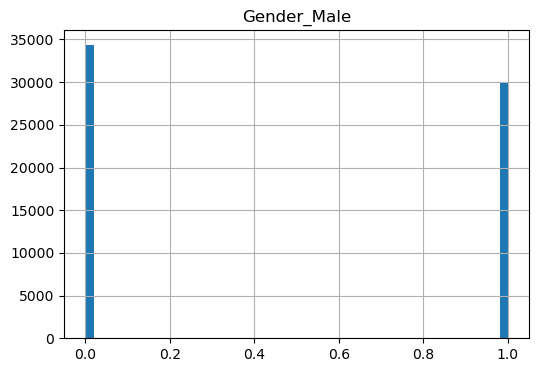

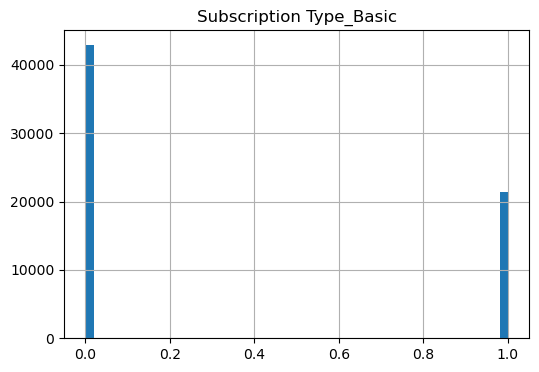

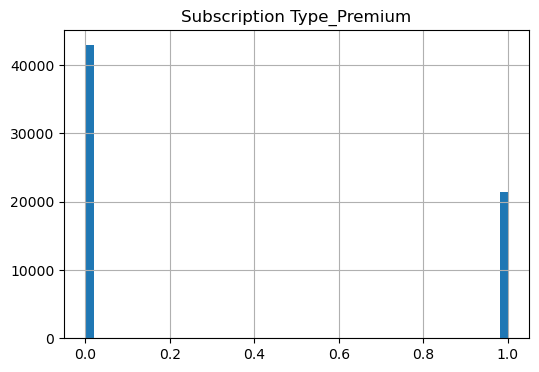

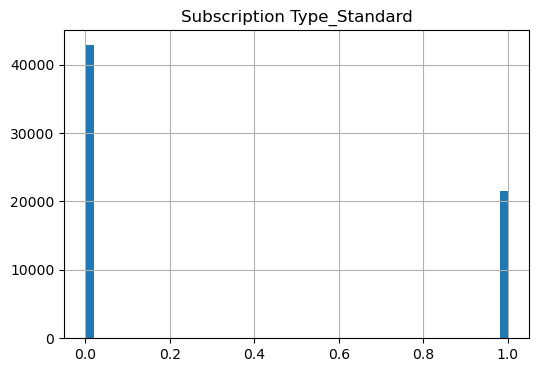

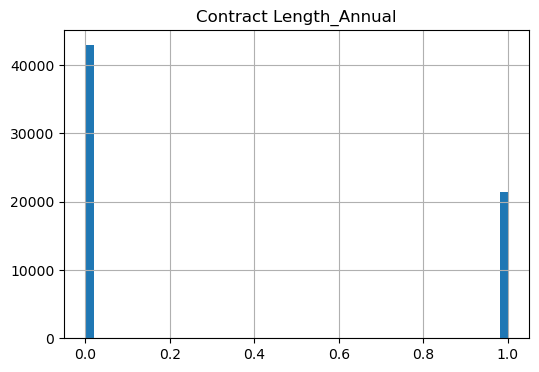

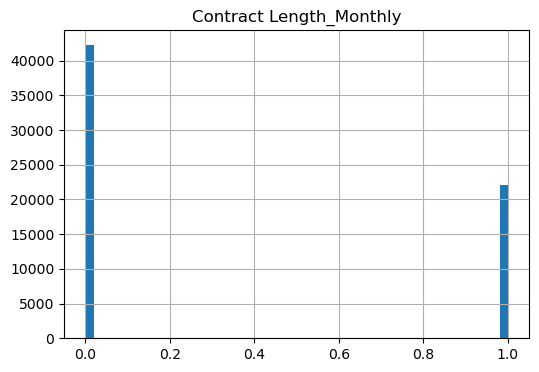

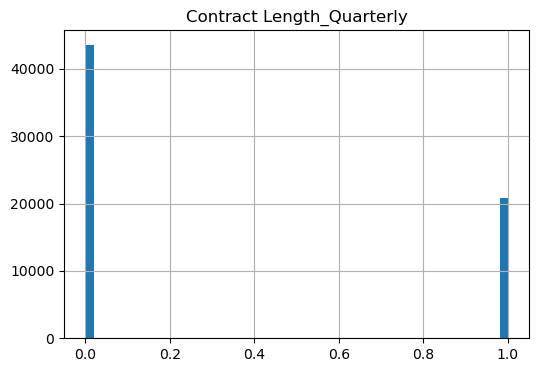

In [21]:
for column in test_data_mdf.columns:
    fig, ax = plt.subplots(figsize=(6, 4))  # Adjust figsize as needed
    test_data_mdf[column].hist(bins=50, ax=ax)
    plt.title(f"{column}")
    plt.show()

<Axes: >

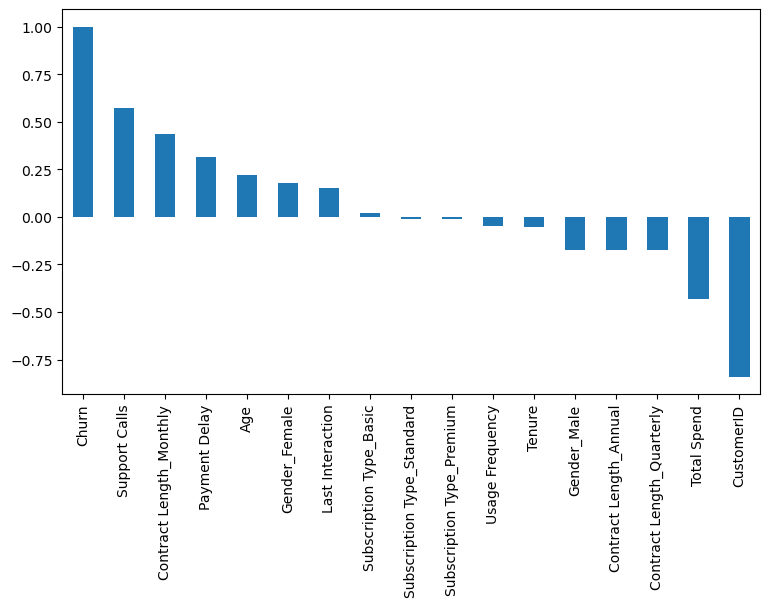

In [22]:
fig, ax = plt.subplots(figsize=(9,5))
train_data_mdf.corr()["Churn"].sort_values(ascending=False).plot(kind="bar", ax=ax)

In [23]:
X_train = train_data_mdf.drop(['CustomerID','Churn'],axis=1)
y_train = train_data_mdf['Churn'].astype(int)
X_test = test_data_mdf.drop(['CustomerID','Churn'],axis=1)
y_test = test_data_mdf['Churn'].astype(int)

In [24]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((440832, 15), (440832,), (64374, 15), (64374,))

# Scaling Data

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Random Forest Classifier

In [26]:
rf_model = RandomForestClassifier(n_estimators= 100, random_state=69, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=69)

In [27]:
rf_scores = cross_val_score(rf_model, X_train, y_train,  scoring='accuracy',cv=10, n_jobs=-1)
print("Cross-Validation Scores:", rf_scores)
print("Mean Accuracy:", rf_scores.mean())

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Cross-Validation Scores: [0.9992968  0.99947827 0.99925141 0.9992741  0.9994102  0.99959168
 0.99938752 0.99938752 0.99936483 0.99938752]
Mean Accuracy: 0.9993829848806437


In [28]:
y_pred_rf = rf_model.predict(X_test)
y_pred_rf

array([1, 1, 1, ..., 1, 1, 1])

In [29]:
print(metrics.classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.98      0.06      0.11     33881
           1       0.49      1.00      0.66     30493

    accuracy                           0.50     64374
   macro avg       0.73      0.53      0.38     64374
weighted avg       0.75      0.50      0.37     64374



In [30]:
print(f'Accuracy:',accuracy_score(y_test, y_pred_rf))
print(f'Precision:',precision_score(y_test, y_pred_rf))
print(f'Recall:',recall_score(y_test, y_pred_rf))
print(f'F1:',f1_score(y_test, y_pred_rf))

Accuracy: 0.5038835554727064
Precision: 0.48842057993328203
Recall: 0.9987210179385433
F1: 0.656018094673919


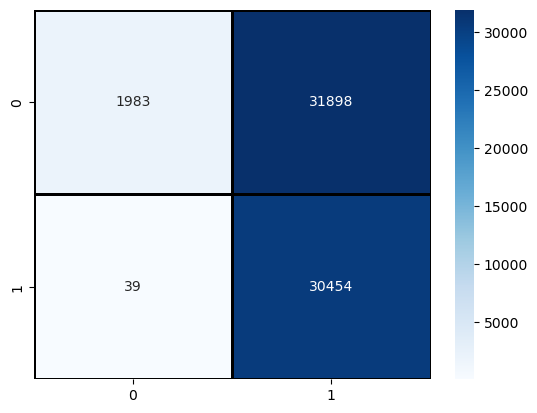

In [31]:
sn.heatmap(confusion_matrix(y_test, y_pred_rf),cmap='Blues', linewidths=1, linecolor='black', annot=True, fmt='d')
plt.show()

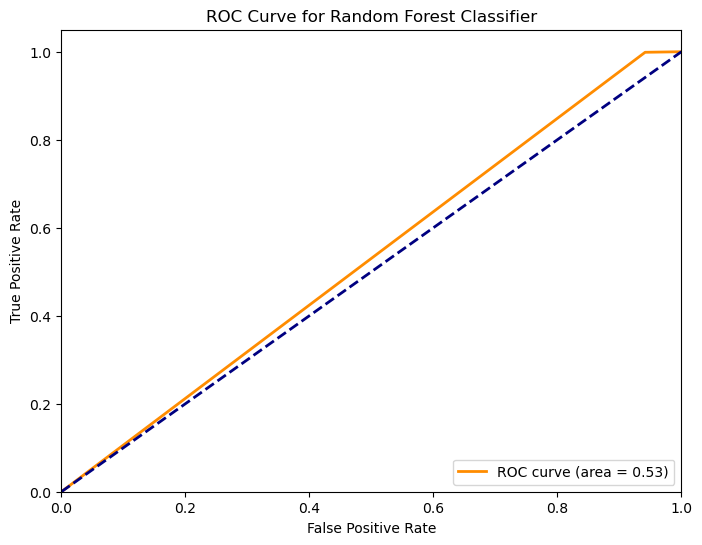

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()

# Logistic Regression

In [33]:
lr_model = LogisticRegression(max_iter =2000)
lr_model.fit(X_train , y_train)

LogisticRegression(max_iter=2000)

In [34]:
scores = cross_val_score(lr_model, X_train, y_train,  scoring='accuracy',cv=10, n_jobs=-1)
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-Validation Scores: [0.89422466 0.89240994 0.89821473 0.89254361 0.8959236  0.89746614
 0.89531112 0.89456253 0.89526575 0.89778373]
Mean Accuracy: 0.8953705813247586


In [35]:
y_pred_lr = lr_model.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred_lr)) 
print(metrics.classification_report(y_test, y_pred_lr))

Accuracy:  0.5712244073694349
              precision    recall  f1-score   support

           0       0.96      0.19      0.32     33881
           1       0.53      0.99      0.69     30493

    accuracy                           0.57     64374
   macro avg       0.74      0.59      0.50     64374
weighted avg       0.75      0.57      0.49     64374



In [36]:
print(f'Accuracy:',accuracy_score(y_test, y_pred_lr))
print(f'Precision:',precision_score(y_test, y_pred_lr))
print(f'Recall:',recall_score(y_test, y_pred_lr))
print(f'F1:',f1_score(y_test, y_pred_lr))

Accuracy: 0.5712244073694349
Precision: 0.5251299525390727
Recall: 0.9905880038041518
F1: 0.6863908014634036


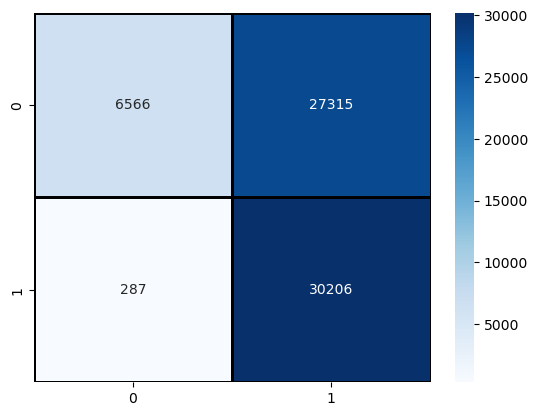

In [37]:
sn.heatmap(confusion_matrix(y_test, y_pred_lr),cmap='Blues', linewidths=1, linecolor='black', annot=True, fmt='d')
plt.show()

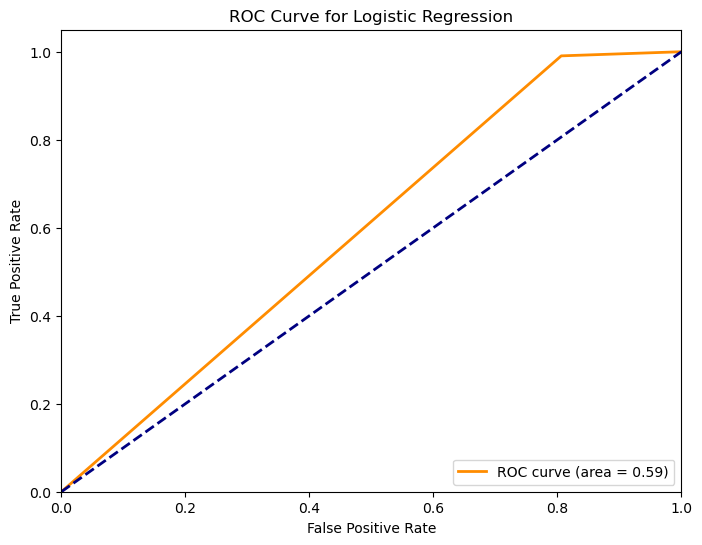

In [38]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# Artificial Nueral Networks

In [39]:
nueral_model = Sequential()
nueral_model.add(Dense(5,activation='relu',input_dim=15))
nueral_model.add(Dense(3,activation='relu'))
nueral_model.add(Dense(1,activation='sigmoid'))
# Compile the model
nueral_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = nueral_model.fit(X_train, y_train, epochs=10,validation_split=0.2)

Epoch 1/10
11021/11021 [==============================] - 29s 3ms/step - loss: 0.2012 - accuracy: 0.9142 - val_loss: 0.1992 - val_accuracy: 0.9484
Epoch 2/10
11021/11021 [==============================] - 28s 3ms/step - loss: 0.1203 - accuracy: 0.9531 - val_loss: 0.1263 - val_accuracy: 0.9681
Epoch 3/10
11021/11021 [==============================] - 28s 3ms/step - loss: 0.0816 - accuracy: 0.9698 - val_loss: 0.0929 - val_accuracy: 0.9791
Epoch 4/10
11021/11021 [==============================] - 27s 2ms/step - loss: 0.0704 - accuracy: 0.9749 - val_loss: 0.0894 - val_accuracy: 0.9784
Epoch 5/10
11021/11021 [==============================] - 28s 3ms/step - loss: 0.0663 - accuracy: 0.9765 - val_loss: 0.0766 - val_accuracy: 0.9823
Epoch 6/10
11021/11021 [==============================] - 29s 3ms/step - loss: 0.0646 - accuracy: 0.9770 - val_loss: 0.0847 - val_accuracy: 0.9767
Epoch 7/10
11021/11021 [==============================] - 29s 3ms/step - loss: 0.0635 - accuracy: 0.9775 - val_loss: 0

In [40]:
nueral_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 80        
                                                                 
 dense_1 (Dense)             (None, 3)                 18        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 102
Trainable params: 102
Non-trainable params: 0
_________________________________________________________________


In [41]:
from sklearn.metrics import classification_report

loss, accuracy = nueral_model.evaluate(X_test, y_test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

# Predict classes for the test data
y_pred_prob = nueral_model.predict(X_test)
y_pred_nm = (y_pred_prob > 0.5).astype(int) #model prediction

print('\n Confusion Matrix')
print(confusion_matrix(y_test, y_pred_nm))

print(f'Accuracy:',accuracy_score(y_test, y_pred_nm))
print(f'Precision:',precision_score(y_test, y_pred_nm))
print(f'Recall:',recall_score(y_test, y_pred_nm))
print(f'F1:',f1_score(y_test, y_pred_nm))

2012/2012 [==============================] - 4s 2ms/step - loss: 36.3208 - accuracy: 0.5163
Loss: 36.32082748413086
Accuracy: 0.5163264870643616
2012/2012 [==============================] - 3s 1ms/step

 Confusion Matrix
[[ 2826 31055]
 [   81 30412]]
Accuracy: 0.5163264672072576
Precision: 0.4947695511412628
Recall: 0.9973436526415899
F1: 0.6614180078294911


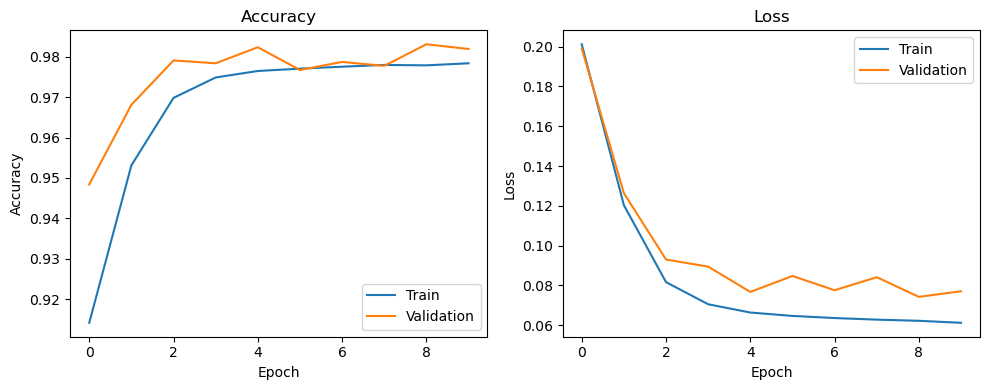

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Accuracy subplot
axes[0].set_title('Accuracy')
axes[0].plot(history.history['accuracy'], label='Train')
axes[0].plot(history.history['val_accuracy'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Loss subplot
axes[1].set_title('Loss')
axes[1].plot(history.history['loss'], label='Train')
axes[1].plot(history.history['val_loss'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

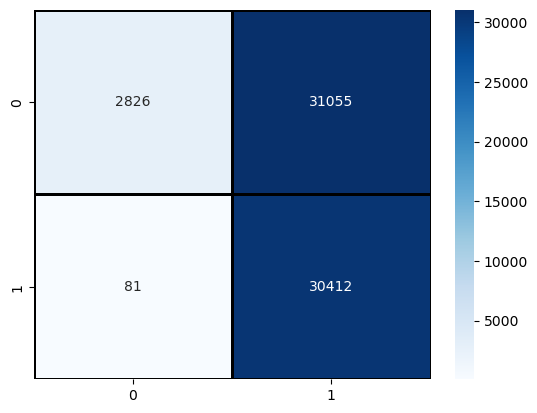

In [43]:
sn.heatmap(confusion_matrix(y_test, y_pred_nm),cmap='Blues', linewidths=1, linecolor='black', annot=True, fmt='d')
plt.show()

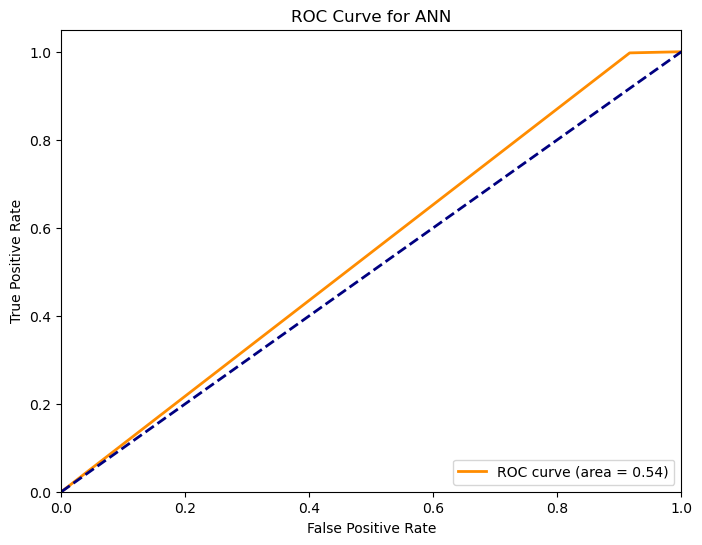

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_nm)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ANN')
plt.legend(loc='lower right')
plt.show()

# XG Boost

In [45]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=3)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=3, ...)

In [46]:
scores = cross_val_score(xgb_model, X_train, y_train,  scoring='accuracy',cv=10, n_jobs=-1)
print("Mean Accuracy:", scores.mean())

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Mean Accuracy: 0.9999727787250594


In [47]:
y_pred_xgb = xgb_model.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f'Accuracy:',accuracy_score(y_test, y_pred_xgb))
print(f'Precision:',precision_score(y_test, y_pred_xgb))
print(f'Recall:',recall_score(y_test, y_pred_xgb))
print(f'F1:',f1_score(y_test, y_pred_xgb))

Accuracy: 0.5032466523751825
Precision: 0.48809962656067185
Recall: 0.9987210179385433
F1: 0.655728527442241


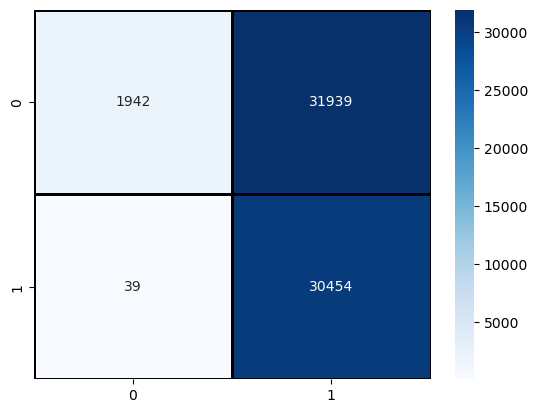

In [52]:
sn.heatmap(confusion_matrix(y_test, y_pred_xgb),cmap='Blues', linewidths=1, linecolor='black', annot=True, fmt='d')
plt.show()

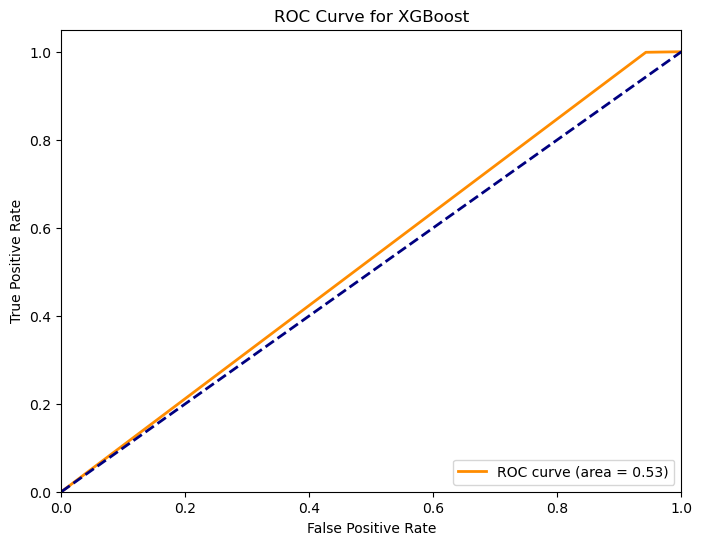

In [49]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc='lower right')
plt.show()

# Conclusion

The Logistic Regression algorithm gave highest accuracy and F1 score.